
# Forecast

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers import SpectralNormalization as SN
from tensorflow.keras.metrics import CategoricalAccuracy as Acc
from tensorflow.keras.losses import CategoricalCrossentropy as cc
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod as FGSM, CarliniLInfMethod as CW, BoundaryAttack as BA, DeepFool as DF, \
                                BasicIterativeMethod as BIM, NewtonFool as NF, ElasticNet as EN, \
                                ProjectedGradientDescentTensorFlowV2 as PGD

In [2]:
%matplotlib inline
file_name = 'attack_classif'
dir_name = file_name + '_dir'
weights_dir = 'classif_dublu_lstm_v3_dir/ckpt'
#os.mkdir(dir_name)

In [3]:
data = np.load('../../data/processed/normalized_generated_data.npz')
electrical_data = data['electrical_data']
labels = data['labels']

In [10]:
x = np.load('attack_classif_metrics.npz', allow_pickle=True)

In [21]:
with_eps = ['FGSM', 'BIM', 'PGD', 'CW'] # With a maximum perturbation allowed
without_eps = ['BA', 'EN', 'DF', 'NF']
with_eps_names = ['Orig'] + with_eps
all_names = with_eps_names + without_eps
attack_vals_np = {}
labeled_attack_vals_np = {}
targeted_attack_vals_np = {}

for i, k in enumerate(x.keys()):
    print(k)
    if i < 9:
        attack_vals_np[all_names[i]] = x[k]
    elif i < 18:
        labeled_attack_vals_np[all_names[i - 9]] = x[k]
    else:
        targeted_attack_vals_np[all_names[i - 18]] = x[k]

print(all_names)

unlabeled_Orig
unlabeled_FGSM
unlabeled_BIM
unlabeled_PGD
unlabeled_CW
unlabeled_BA
unlabeled_EN
unlabeled_DF
unlabeled_NF
labeled_Orig
labeled_FGSM
labeled_BIM
labeled_PGD
labeled_CW
labeled_BA
labeled_EN
labeled_DF
labeled_NF
targeted_Orig
targeted_FGSM
targeted_BIM
targeted_PGD
targeted_CW
targeted_BA
targeted_EN
['Orig', 'FGSM', 'BIM', 'PGD', 'CW', 'BA', 'EN', 'DF', 'NF']


In [20]:
for i in range(1, 3):
    for j, results_dict in enumerate([attack_vals_np, labeled_attack_vals_np, targeted_attack_vals_np]):
        without_eps_names = ['BA', 'EN'] if j == 2 else without_eps
        best_vals = [results_dict[attack][-1, i] for attack in with_eps_names]
        best_vals += [results_dict[attack][i] for attack in without_eps_names]
        print([round(nr, 3) for nr in best_vals])
        print()

[0.962, 0.088, 0.018, 0.02, 0.47, 0.026, 0.342, 0.076, 0.198]

[0.962, 0.066, 0.0, 0.0, 0.35, 0.018, 0.332, 0.076, 0.198]

[0.962, 0.054, 0.0, 0.0, 0.646, 0.132, 0.384]

[0.0, 0.097, 0.078, 0.079, 0.003, 0.101, 0.101, 0.165, 0.003]

[0.0, 0.097, 0.078, 0.079, 0.005, 0.101, 0.099, 0.165, 0.003]

[0.0, 0.097, 0.07, 0.07, 0.004, 0.109, 0.13]



## Split Data

In [4]:
nr_outputs = 5
batch_size = 32
input_shape=electrical_data.shape[1:3]

In [5]:
def split_data(data, labels):
    labels = labels[:, 2] - 12
    one_hot = np.zeros((labels.size, nr_outputs))
    one_hot[np.arange(labels.size), labels] = 1
    labels = one_hot
    train_factor, val_factor = 0.8, 0.1
    train_limit, val_limit = int(len(data) * train_factor), int(len(data) * (train_factor + val_factor))
    train_data, train_labels = data[:train_limit], labels[:train_limit]
    val_data, val_labels = data[train_limit:val_limit], labels[train_limit:val_limit]
    test_data, test_labels = data[val_limit:], labels[val_limit:]
    return train_data, train_labels, val_data, val_labels, test_data, test_labels

In [6]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = split_data(electrical_data, labels)

## Building the Model

In [7]:
def conv_block(kernel_size, filters, padding, input_layer):
    sn_conv_1d = SN(Conv1D(kernel_size=kernel_size, filters=filters, padding=padding))(input_layer)
    bn = BatchNormalization()(sn_conv_1d)
    act = Activation('relu')(bn)
    mp_1d = MaxPooling1D()(act)
    res = Dropout(0.2)(mp_1d)
    return res

In [8]:
def create_model():
    # Commented lines were used when ART was tested with logits, not probabilities
    sampled_data = Input(input_shape, name='input_data')
    padding = "valid"
    conv1 = conv_block(4, 16, padding, sampled_data)
    conv2 = conv_block(4, 32, padding, conv1)
    conv3 = conv_block(4, 64, padding, conv2)
    conv4 = conv_block(4, 128, padding, conv3)
    conv5 = conv_block(4, 256, padding, conv4)
    conv6 = conv_block(4, 512, padding, conv5)
    flat = Flatten()(conv6)
    res = SN(Dense(nr_outputs, activation='softmax'))(flat)
    #res = Lambda(lambda x: tf.math.log(x / tf.math.maximum((1 - x), 1e-9)))(res)
    model = Model(sampled_data, res, name="Classifier")
    #model.compile(optimizer = Adam(1e-3, 0.5, 0.9), loss = cc(from_logits=True), metrics=[Acc(name='acc')])
    model.compile(optimizer = Adam(1e-3, 0.5, 0.9), loss = cc(), metrics=[Acc(name='acc')])
    return model

model = create_model()

In [9]:
model.load_weights(weights_dir + '/gen_weights.ckpt')

## Test the Model

In [11]:
classifier = TensorFlowV2Classifier(model=model, nb_classes=nr_outputs, input_shape=input_shape, clip_values=(-1, 1), \
                                   loss_object=cc())
attack_vals = {} # Untargeted, without labels
labeled_attack_vals = {} # Untargeted, with labels
targeted_attack_vals = {} # Targeted
interval = np.linspace(0.01, 0.1, 10)
batch_size = 64
max_iter = 50
with_eps = ['FGSM', 'BIM', 'PGD', 'CW'] # With a maximum perturbation allowed
without_eps = ['BA', 'EN', 'DF', 'NF']
sample_index = 7
target_labels = np.array([[0, 0, 0, 0, 1] if lb[4] == 0 else [1, 0, 0, 0, 0] for lb in test_labels])

In [19]:
loss_test, accuracy_test = model.evaluate(test_data, test_labels)
clean_result = (loss_test, accuracy_test, 0., test_data[sample_index])
clean_results = [clean_result for _ in range(len(interval) + 1)]
attack_vals['Orig'] = clean_results
labeled_attack_vals['Orig'] = clean_results
targeted_attack_vals['Orig'] = clean_results

16/16 [==============================] - 1s 72ms/step - loss: 0.1106 - acc: 0.9620


## Attacks with a maximum perturbation

In [78]:
for attack_name in with_eps:
    if attack_name == 'Orig':
        continue
    print(attack_name)
    attack_type = eval(attack_name)
    for results_dict, targeted, y in [(attack_vals, False, None), (labeled_attack_vals, False, test_labels), \
                                      (targeted_attack_vals, True, target_labels)]:
        vals = []
        for eps in interval:
            params = {'batch_size': batch_size, 'targeted': targeted, 'eps': eps}
            if attack_name == 'PGD':
                params['num_random_init'] = 1
            if attack_name != 'CW':
                params['eps_step'] = eps / 3
            if attack_name != 'FGSM':
                params['max_iter'] = max_iter
            attack = attack_type(classifier, **params)
            test_data_adv = attack.generate(x=test_data, y=y)
            loss_test, accuracy_test = model.evaluate(test_data_adv, test_labels)
            perturbation = np.nanmean(np.abs((test_data_adv - test_data)))
            vals.append((loss_test, accuracy_test, perturbation, test_data_adv[sample_index]))
        results_dict[attack_name] = vals

FGM
16/16 [==============================] - 0s 13ms/step - loss: 8.7684 - acc: 0.0540
BIM


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.3182 - acc: 0.8640


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 1.1779 - acc: 0.6280


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 3.0632 - acc: 0.3200


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 6.4603 - acc: 0.0480


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 11.3739 - acc: 0.0220


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 17.6142 - acc: 0.0200


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 24.9451 - acc: 0.0180


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 33.2196 - acc: 0.0180


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 42.4410 - acc: 0.0180


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 52.2259 - acc: 0.0180


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.4530 - acc: 0.8420


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - ETA: 0s - loss: 1.4667 - acc: 0.601 - 0s 13ms/step - loss: 1.4257 - acc: 0.6060


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 3.4255 - acc: 0.3000


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 6.9472 - acc: 0.0280


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 12.0143 - acc: 0.0020


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 18.4671 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 25.9243 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 34.3908 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 43.8214 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 53.8369 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.2292 - acc: 0.9300


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 0.6577 - acc: 0.8000


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 1.9788 - acc: 0.4620


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 5.1777 - acc: 0.0620


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 10.3767 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 15.6742 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 19.5015 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 24.0303 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 29.1658 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 36.0587 - acc: 0.0000e+00
PGD


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.3182 - acc: 0.8640


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 1.1779 - acc: 0.6280


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 3.0632 - acc: 0.3200


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 6.4603 - acc: 0.0480


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 11.3739 - acc: 0.0220


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 17.6142 - acc: 0.0200


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 24.9451 - acc: 0.0180


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 33.2196 - acc: 0.0180


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 42.4410 - acc: 0.0180


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 52.2259 - acc: 0.0180


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.4530 - acc: 0.8420


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 1.4257 - acc: 0.6060


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 3.4255 - acc: 0.3000


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 6.9472 - acc: 0.0280


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 12.0143 - acc: 0.0020


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 18.4671 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 25.9243 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 34.3908 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 43.8214 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 53.8369 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.2292 - acc: 0.9300


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.6577 - acc: 0.8000


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 1.9788 - acc: 0.4620


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 5.1777 - acc: 0.0620


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 10.3767 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 15.6742 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 19.5015 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 24.0303 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 29.1658 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 36.0587 - acc: 0.0000e+00
CW


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.3038 - acc: 0.7900


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.4351 - acc: 0.6460


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.5521 - acc: 0.5840


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.5855 - acc: 0.5860


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.7440 - acc: 0.5400


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.7677 - acc: 0.5200


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.8976 - acc: 0.4880


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.9850 - acc: 0.4800


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.9999 - acc: 0.4800


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 1.1909 - acc: 0.4700


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.3431 - acc: 0.7440


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 0.4970 - acc: 0.5820


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 0.6389 - acc: 0.5160


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 0.7677 - acc: 0.4580


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 0.9347 - acc: 0.4280


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 0.9820 - acc: 0.3900


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 1.1444 - acc: 0.3840


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 1.4056 - acc: 0.3600


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 1.4008 - acc: 0.3620


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 1.5006 - acc: 0.3500


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 0.2256 - acc: 0.8560


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 0.3243 - acc: 0.7820


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.4240 - acc: 0.7360


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.5541 - acc: 0.6780


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - ETA: 0s - loss: 0.6283 - acc: 0.711 - 0s 13ms/step - loss: 0.6227 - acc: 0.7080


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.7406 - acc: 0.6660


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.8208 - acc: 0.6780


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.9268 - acc: 0.6640


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 1.1127 - acc: 0.6500


C&W L_inf:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 1.2284 - acc: 0.6460


In [18]:
attack_name = 'PGD'
print(attack_name)
attack_type = eval(attack_name)
for results_dict, targeted, y in [(attack_vals, False, None), (labeled_attack_vals, False, test_labels), \
                                  (targeted_attack_vals, True, target_labels)]:
    vals = []
    for eps in interval:
        params = {'batch_size': batch_size, 'targeted': targeted, 'eps': eps, 'eps_step': eps / 3, 'max_iter': max_iter, \
                  'num_random_init': 1}
        attack = attack_type(classifier, **params)
        test_data_adv = attack.generate(x=test_data, y=y)
        loss_test, accuracy_test = model.evaluate(test_data_adv, test_labels)
        perturbation = np.nanmean(np.abs((test_data_adv - test_data)))
        vals.append((loss_test, accuracy_test, perturbation, test_data_adv[sample_index]))
    results_dict[attack_name] = vals

PGD


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 75ms/step - loss: 0.3170 - acc: 0.8660


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 77ms/step - loss: 1.1649 - acc: 0.6280


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 72ms/step - loss: 3.0198 - acc: 0.3220


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 74ms/step - loss: 6.3205 - acc: 0.0560


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 78ms/step - loss: 11.2564 - acc: 0.0220


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 71ms/step - loss: 17.5476 - acc: 0.0220


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 76ms/step - loss: 25.1213 - acc: 0.0180


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 87ms/step - loss: 33.7584 - acc: 0.0180


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 77ms/step - loss: 43.3150 - acc: 0.0180


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 71ms/step - loss: 53.2919 - acc: 0.0200


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 74ms/step - loss: 0.4516 - acc: 0.8440


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 71ms/step - loss: 1.4146 - acc: 0.6080


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 74ms/step - loss: 3.3733 - acc: 0.3100


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 74ms/step - loss: 6.8264 - acc: 0.0340


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 74ms/step - loss: 11.9310 - acc: 0.0020


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 75ms/step - loss: 18.4270 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 75ms/step - loss: 26.1072 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 76ms/step - loss: 34.9264 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 76ms/step - loss: 44.9252 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 75ms/step - loss: 54.7036 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 74ms/step - loss: 0.2286 - acc: 0.9280


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 77ms/step - loss: 0.6506 - acc: 0.8020


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 75ms/step - loss: 1.9482 - acc: 0.4640


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 74ms/step - loss: 5.0830 - acc: 0.0720


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 75ms/step - loss: 10.2734 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 76ms/step - loss: 15.4761 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 76ms/step - loss: 19.3878 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 77ms/step - loss: 23.8579 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 72ms/step - loss: 29.3081 - acc: 0.0000e+00


PGD - Batches: 0it [00:00, ?it/s]

16/16 [==============================] - 1s 71ms/step - loss: 35.6276 - acc: 0.0000e+00


## Attacks without a maximum perturbation

In [79]:
for attack_name in without_eps:
    print(attack_name)
    attack_type = eval(attack_name)
    for results_dict, targeted, y in [(attack_vals, False, None), (labeled_attack_vals, False, test_labels), \
                                      (targeted_attack_vals, True, target_labels)]:
        params = {'batch_size': batch_size, 'max_iter': max_iter}
        if attack_name in ['DF', 'NF']:
            if targeted:
                break
        else:
            params['targeted'] = targeted
        attack = attack_type(classifier, **params)
        test_data_adv = attack.generate(x=test_data, y=y)
        loss_test, accuracy_test = model.evaluate(test_data_adv, test_labels)
        perturbation = np.nanmean(np.abs((test_data_adv - test_data)))
        results_dict[attack_name] = (loss_test, accuracy_test, perturbation, test_data_adv[sample_index])

BA


Boundary attack:   0%|          | 0/500 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step - loss: 0.9613 - acc: 0.0260


Boundary attack:   0%|          | 0/500 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 0.9419 - acc: 0.0180


Boundary attack:   0%|          | 0/500 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 0.9378 - acc: 0.1320
DF


TypeError: __init__() got an unexpected keyword argument 'targeted'

DF
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


DeepFool:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 15ms/step - loss: 30.2448 - acc: 0.0760
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


DeepFool:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 30.2451 - acc: 0.0760
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
NF
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


NewtonFool:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 1.2344 - acc: 0.1980
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


NewtonFool:   0%|          | 0/8 [00:00<?, ?it/s]

16/16 [==============================] - 0s 14ms/step - loss: 1.2344 - acc: 0.1980
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [31]:
for results_dict in [attack_vals, labeled_attack_vals, targeted_attack_vals]:
    for attack_name in with_eps:
        results_dict[attack_name] = np.insert(results_dict[attack_name], 0, clean_result, 0)

attack_vals_np = {k : np.array(v) for k, v in attack_vals.items()}
labeled_attack_vals_np = {k : np.array(v) for k, v in labeled_attack_vals.items()}
targeted_attack_vals_np = {k : np.array(v) for k, v in targeted_attack_vals.items()}

<ipython-input-31-b9735cb84529>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  attack_vals_np_2 = {k : np.array(v) for k, v in attack_vals_2.items()}
<ipython-input-31-b9735cb84529>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  labeled_attack_vals_np_2 = {k : np.array(v) for k, v in labeled_attack_vals_2.items()}
<ipython-input-31-b9735cb84529>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do th

## For me: load data saved yesterday

In [21]:
attack_vals = {} # Untargeted, without labels
labeled_attack_vals = {} # Untargeted, with labels
targeted_attack_vals = {} # Targeted

for i in range(1, 4):
    attacks_vals = np.load(dir_name + '/attack_classif_metrics' + str(i) + '.npz', allow_pickle=True)
    for k, v in attacks_vals.items():
        if 'unlabeled' in k:
            attack_vals[k[len('unlabeled_'):]] = v
        elif 'labeled' in k:
            labeled_attack_vals[k[len('labeled_'):]] = v
        else: # targeted
            targeted_attack_vals[k[len('targeted_'):]] = v

## Plot results

In [71]:
attack_vals_np = {k : np.array(v) for k, v in attack_vals.items()}
labeled_attack_vals_np = {k : np.array(v) for k, v in labeled_attack_vals.items()}
targeted_attack_vals_np = {k : np.array(v) for k, v in targeted_attack_vals.items()}

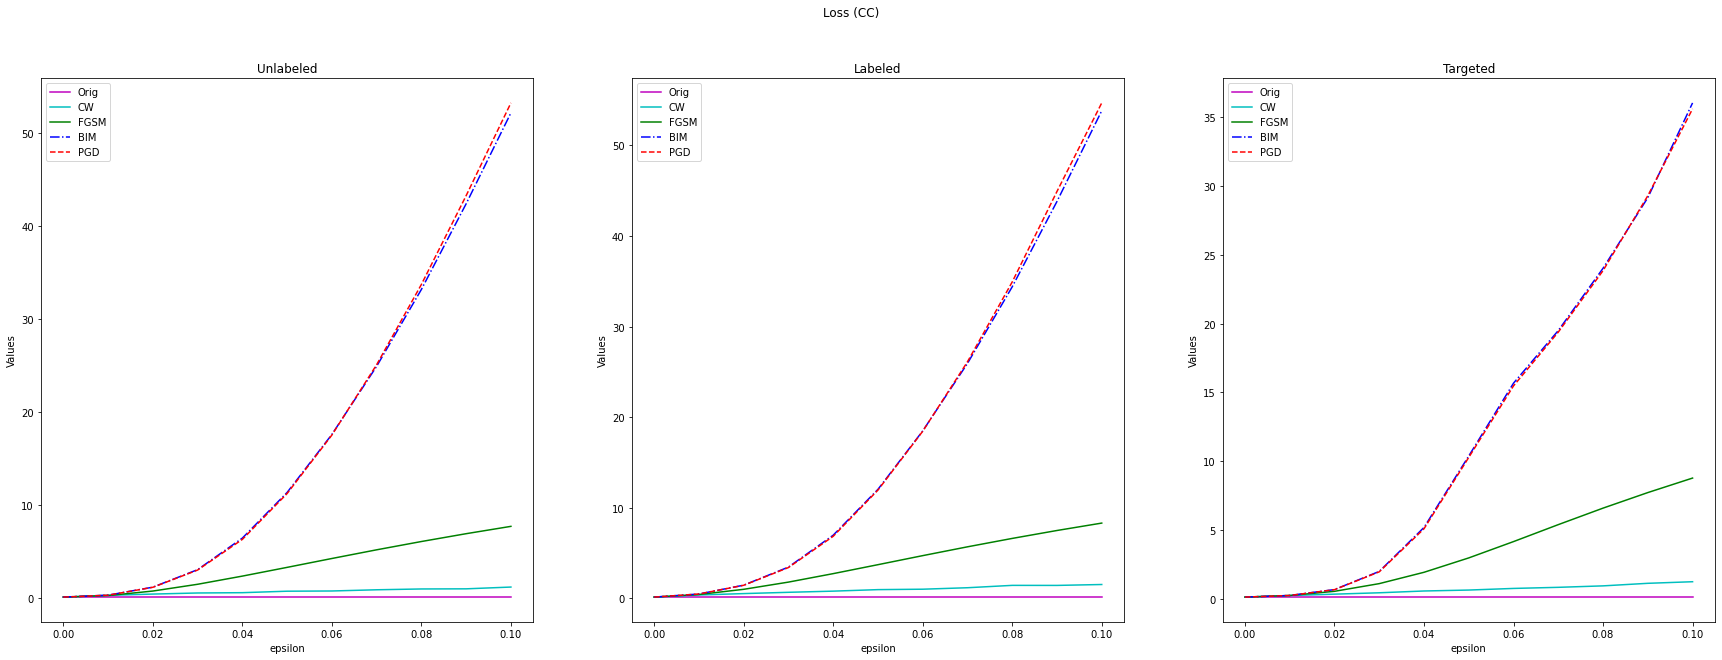

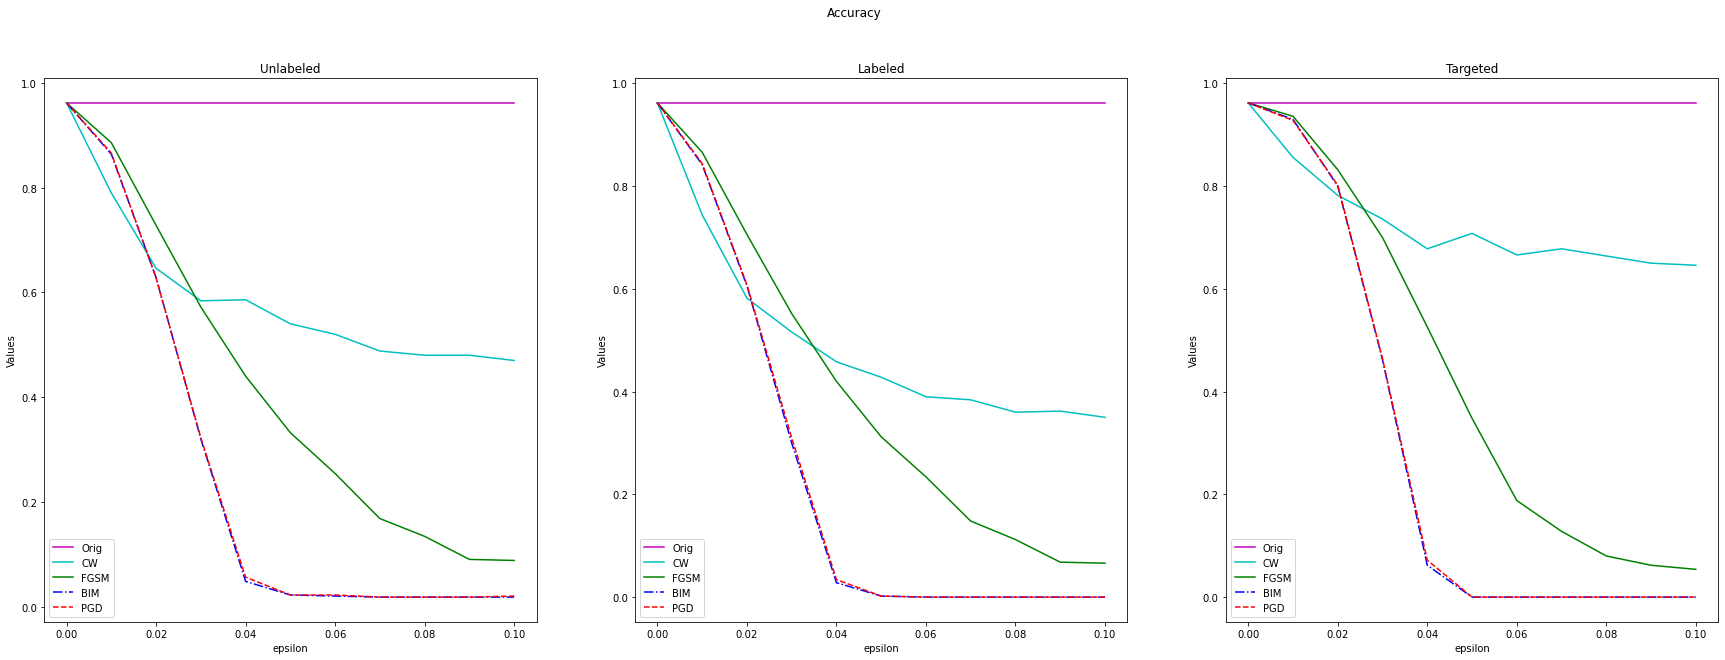

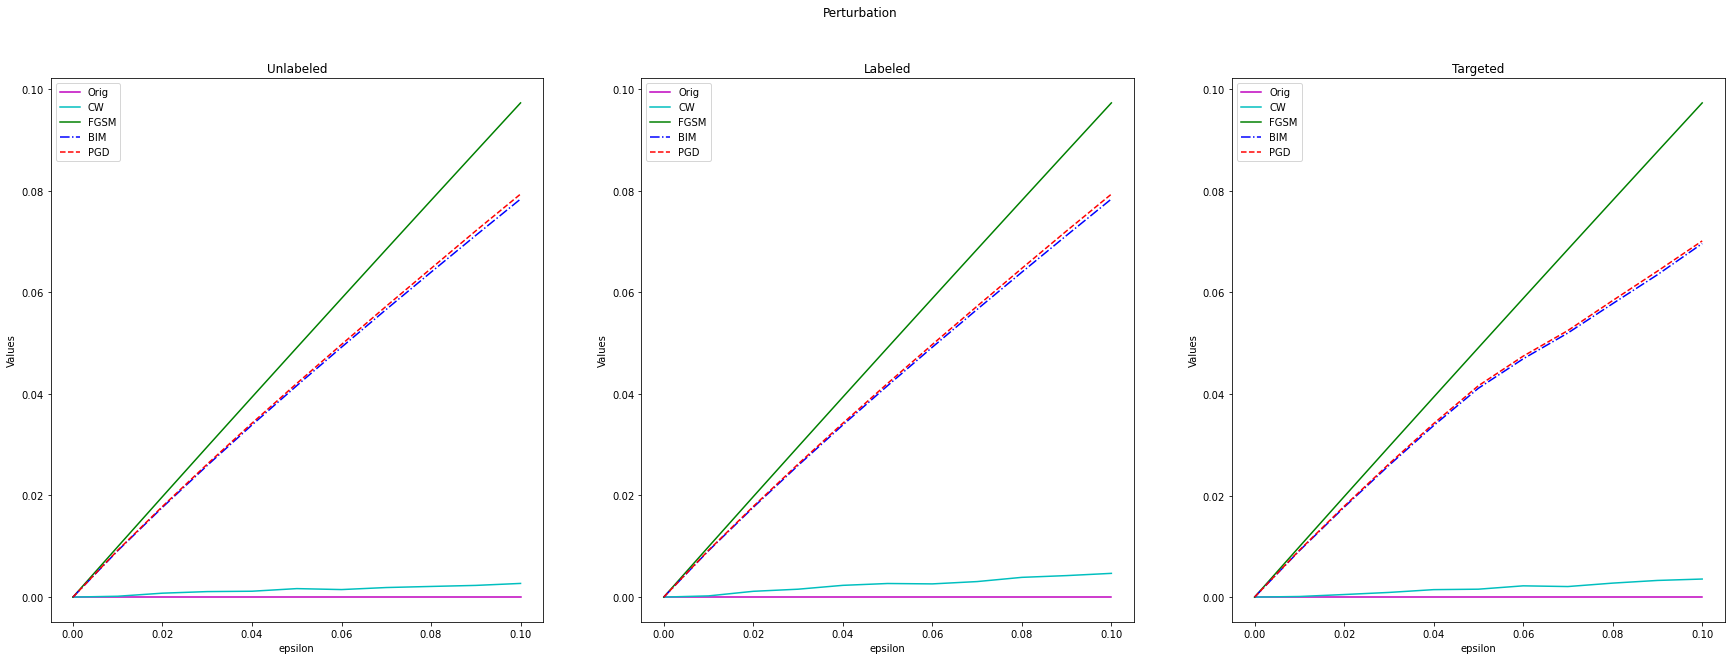

In [61]:
result_types = ['Unlabeled', 'Labeled', 'Targeted']
colors = ['m', 'c', 'g', 'b', 'r']
linestyles=['-', '-','-','-.','--']
plot_interval = np.linspace(0., 0.1, 11)
plot_names = ['CW', 'FGSM', 'BIM', 'PGD']
for i, metric in enumerate(['Loss (CC)', 'Accuracy', 'Perturbation']):
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(30, 10)
    fig.suptitle(metric)
    for j, results_dict in enumerate([attack_vals_np, labeled_attack_vals_np, targeted_attack_vals_np]):
        ax = axs[j]
        ax.title.set_text(result_types[j])
        ax.set_xlabel('epsilon')
        ax.set_ylabel('Values')
        ax.plot(plot_interval, results_dict['Orig'][:, i], color=colors[0], linestyle=linestyles[0], label='Orig')
        for k, attack in enumerate(plot_names, 1):
            val = results_dict[attack][:, i]
            ax.plot(plot_interval, val, color=colors[k], linestyle=linestyles[k], label=attack)
        ax.legend()

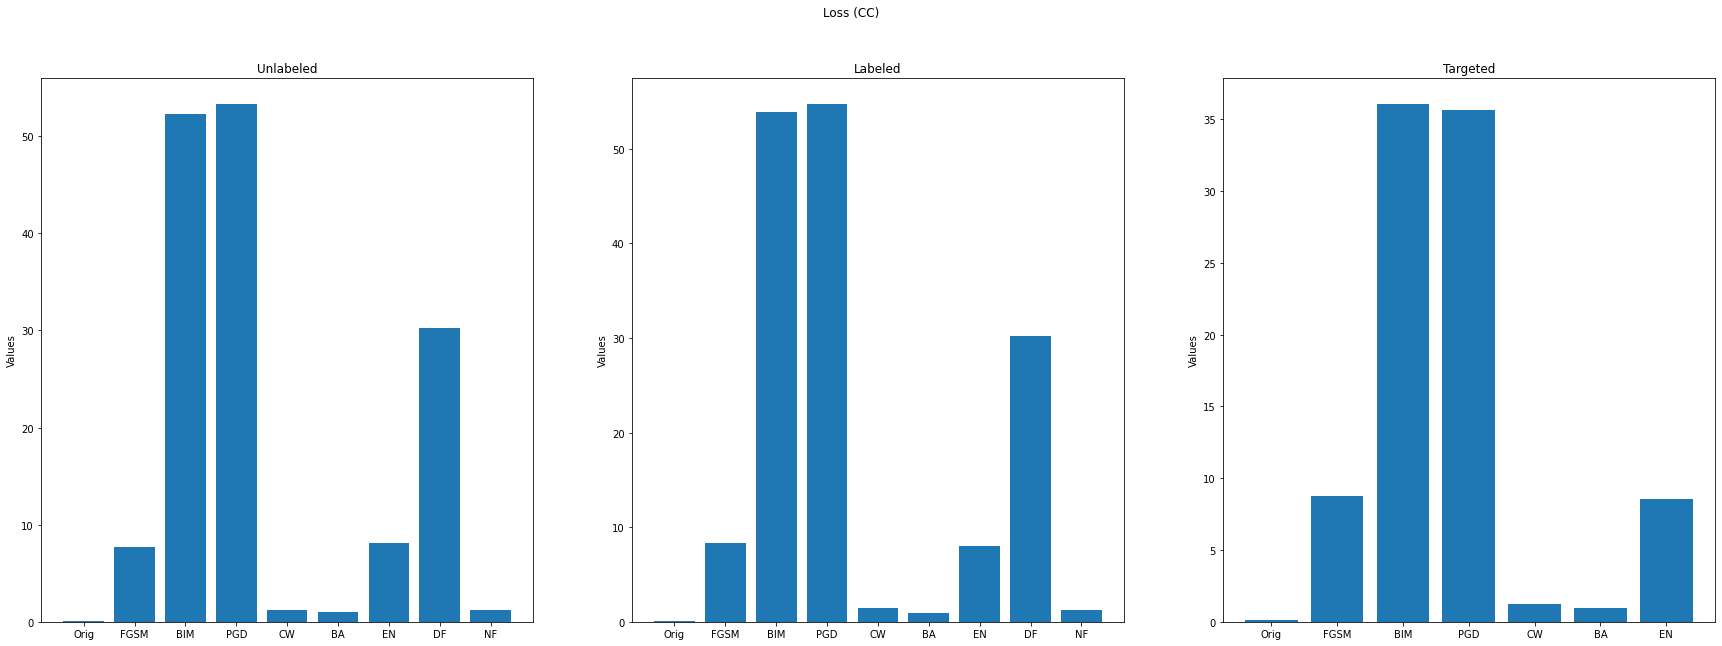

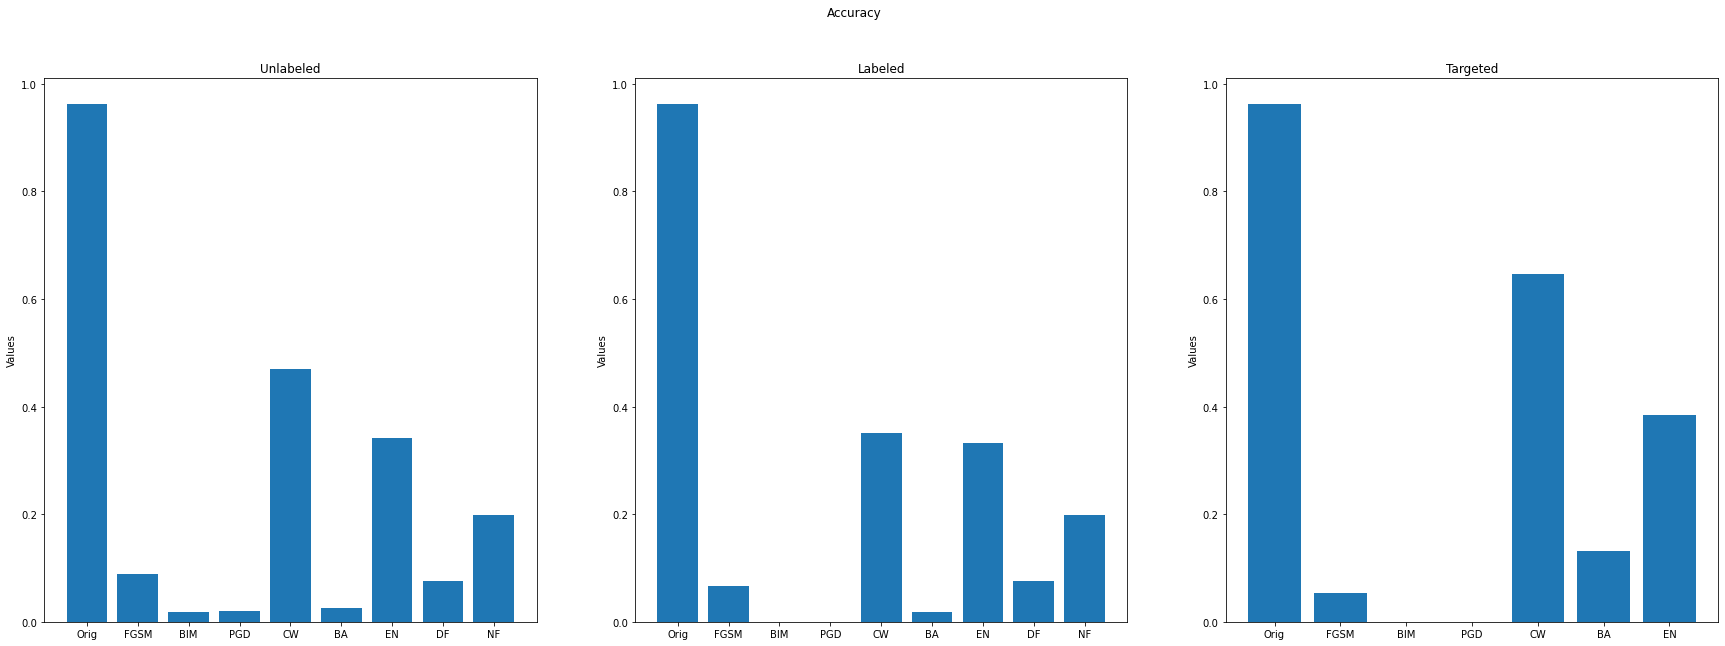

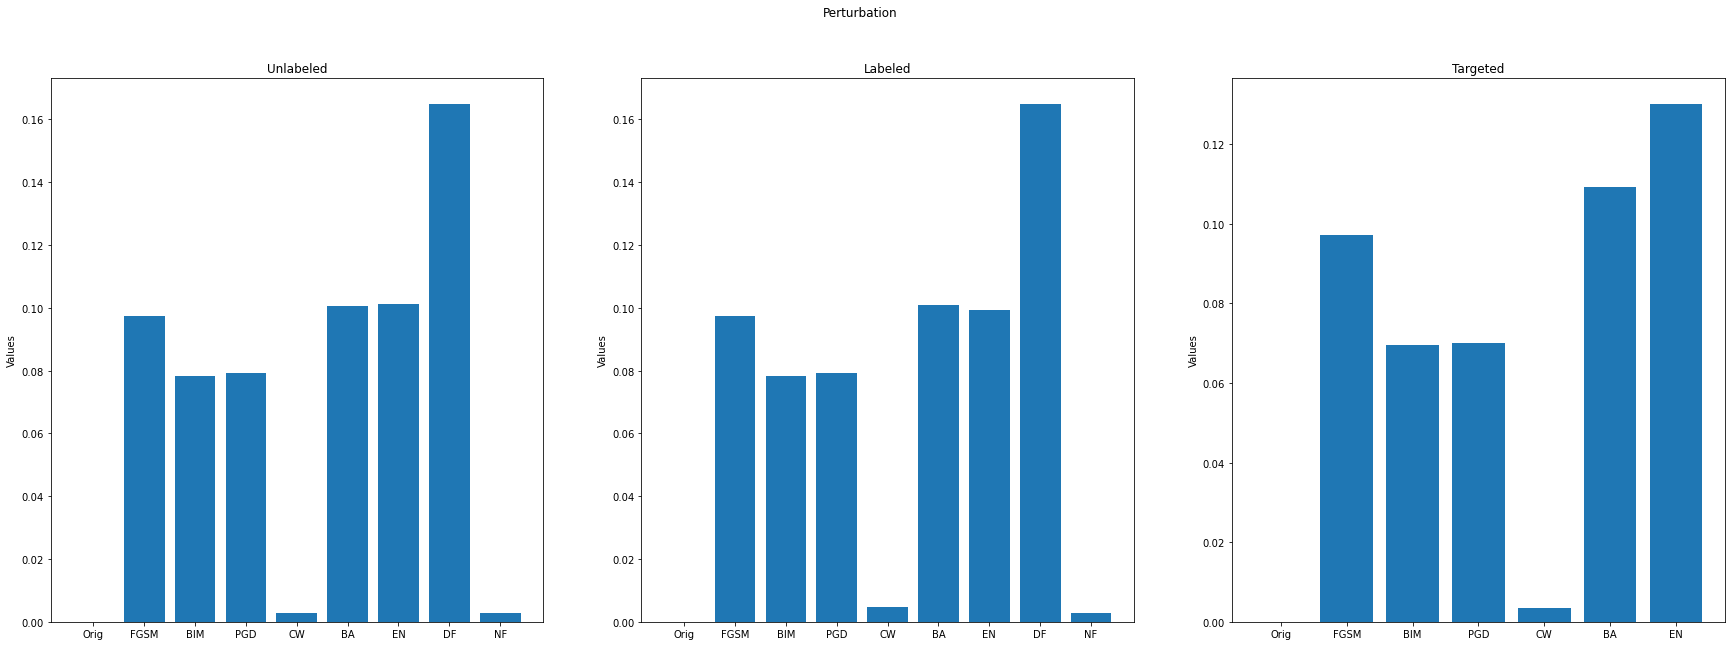

In [56]:
with_eps_names = ['Orig'] + with_eps
for i, metric in enumerate(['Loss (CC)', 'Accuracy', 'Perturbation']):
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(30, 10)
    fig.suptitle(metric)
    for j, results_dict in enumerate([attack_vals_np, labeled_attack_vals_np, targeted_attack_vals_np]):
        without_eps_names = ['BA', 'EN'] if j == 2 else without_eps
        attack_names = [k for k in results_dict.keys()]
        ax = axs[j]
        ax.set_ylabel('Values')
        ax.title.set_text(result_types[j])
        best_vals = [results_dict[attack][-1, i] for attack in with_eps_names]
        best_vals += [results_dict[attack][i] for attack in without_eps_names]
        ax.bar(attack_names, best_vals)

In [62]:
attack_vals_2 = {'unlabeled_' + key: val for key, val in attack_vals_np.items()}
labeled_attack_vals_2 = {'labeled_' + key: val for key, val in labeled_attack_vals_np.items()}
targeted_attack_vals_2 = {'targeted_' + key: val for key, val in targeted_attack_vals_np.items()}
np.savez_compressed(dir_name + '/attack_classif_metrics.npz', **attack_vals_2, **labeled_attack_vals_2, **targeted_attack_vals_2)